# Gradiente Descendente Paralelo 
#### Estudo de Abordagens de Implementação
---
**Créditos:**
 Adaptação do código original desenvolvido por [Angad Gill](https://github.com/angadgill) e [Sharath Rao](https://github.com/sharathrao13) com base no paper de Zinkevich, M., Weimer, M., Li, L., & Smola, A. (2010). [Parallelized stochastic gradient descent](http://papers.nips.cc/paper/4006-parallelized-stochastic-gradient-descent). 

## Dataset

Dataset Diamonds, blablabl
~52000 observações com 8 características e preços correspondentes de diamantes, para regressão linear.

In [128]:
%matplotlib inline
from sklearn.datasets import make_regression
from sklearn.model_selection import ShuffleSplit
import numpy as np
from matplotlib import pyplot as plt
import utils
import importlib
importlib.reload(utils)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [129]:
n_samples = 1000
n_features = 100
seed = 1
effective_rank = 100

In [130]:
n_samples = 1000
n_features = 100
seed = 1
effective_rank = 100

In [131]:
X, y = make_regression(n_samples=n_samples, n_features=n_features, 
                       random_state=seed, noise=0.0, effective_rank=effective_rank)

Preparação dos conjuntos para treinamento e testes:

In [132]:
rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)

In [133]:
for train_index, test_index in rs.split(X):
    pass

In [134]:
X_train = X[train_index]
X_test = X[test_index]
y_train = y[train_index]
y_test = y[test_index]

## 
## SGD "Normal" (baseline)

Treinameno do modelo com coleta da taxa de acurácia a cada iteração:

In [135]:
from sklearn.linear_model import SGDRegressor

In [136]:
# Número máximo de iterações:
n_iter = 5000

In [137]:
# Modelo dde regressão do SciKit-Learn
sgd = SGDRegressor(max_iter = n_iter, tol = 0.001)

In [138]:
# Treinamento do modelo e estatísticas
%time sgd.fit(X_train, y_train)

CPU times: user 731 ms, sys: 3.94 ms, total: 735 ms
Wall time: 735 ms


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=5000, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=0.001, verbose=0,
       warm_start=False)

In [139]:
# Availiação
scores_base = []
cost_base = []
sgd = SGDRegressor(max_iter=1, tol=0.001, warm_start=True)
for i in range(n_iter):
    sgd.partial_fit(X_train, y_train)
    scores_base += [sgd.score(X_test, y_test)]
    cost_base += [utils.computeCost(X_test,y_test,sgd.coef_)]

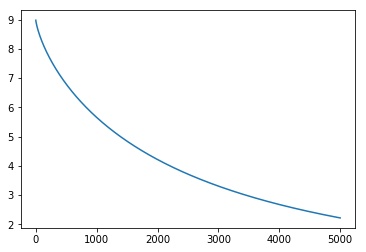

In [140]:
#plt.plot(range(len(scores_base)), scores_base)
plt.plot(range(len(cost_base)),cost_base)

In [141]:
# Acurácia final
scores_base[-1]

0.749204271190011

<Figure size 432x288 with 0 Axes>

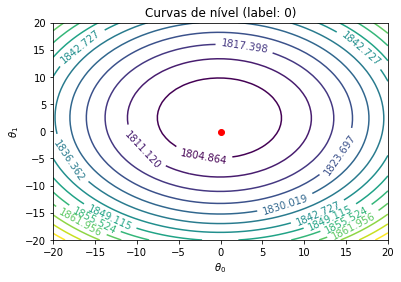

In [142]:
#PCA
X, y = make_regression(n_samples=n_samples, n_features=n_features, 
                       random_state=seed, noise=0.0, effective_rank=effective_rank)
rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)
for train_index, test_index in rs.split(X):
    pass

x_pca = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
x_pca = pca.fit_transform(X)

y_pca = StandardScaler().fit_transform(y.reshape((len(y),1)))
y.shape = (len(y),)

X_train_pca = pc[train_index]
X_test_pca = pc[test_index]
y_train_pca = y[train_index]
y_test_pca = y[test_index]

# Número máximo de iterações:
n_iter = 5000

# Modelo dde regressão do SciKit-Learn
sgd_pca = SGDRegressor(max_iter = n_iter, tol = 0.001)

# Treinamento do modelo e estatísticas
sgd_pca.fit(X_train_pca, y_train_pca)

# Availiação
scores_base_pca = []
cost_base_pca = []
sgd = SGDRegressor(max_iter=1, tol=0.001, warm_start=True)
for i in range(n_iter):
    sgd.partial_fit(X_train_pca, y_train_pca)
    scores_base_pca += [sgd.score(X_test_pca, y_test_pca)]
    cost_base_pca += [utils.computeCost(X_test_pca,y_test_pca,sgd_pca.coef_)]

utils.plot_contour(X_test_pca, y_test_pca, sgd_pca.coef_)


# SGD Paralelo
Comparação de diferentes abordagens de paralelização

In [143]:
from joblib import Parallel, delayed
import utils
import importlib
importlib.reload(utils)

<module 'utils' from '/home/gustavo/Dropbox/mestrado/Paralelo/Trabalho/T1ForReal/utils.py'>

### Cenário 1:
Neste cenário o dataset é dividido em partes iguais e cada uma é atribuída a um worker. Os pesos (parâmetros) finais são calculados uma única vez quando todos terminam o processamento.

In [144]:
# Quantidade de workers
n_jobs = 4

# Treinamento
%time scores,costs, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1/n_jobs, overlap=False)

CPU times: user 29.6 s, sys: 360 ms, total: 30 s
Wall time: 15.2 s


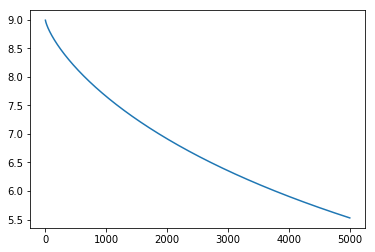

In [145]:
plt.plot(range(len(costs)),costs)

<Figure size 432x288 with 0 Axes>

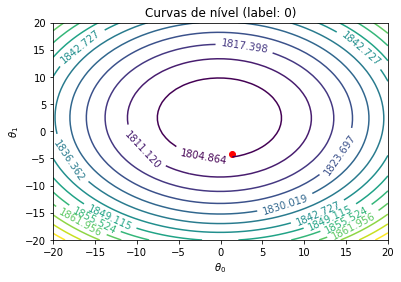

In [146]:
scores,costs, theta = utils.sim_parallel_sgd(X_train_pca, y_train_pca, X_test_pca, y_test_pca, n_iter, n_jobs, split_per_job=1/n_jobs, overlap=False)
utils.plot_contour(X_test_pca, y_test_pca, theta)

### Cenário 2:
Neste cenário, todos os workers tem acesso a todo o conjunto de dados. Os pesos são finais são calculados uma única vez quando todos terminam o processamento.

4 workers:

In [147]:
n_jobs = 4
%time scores_4,costs_4, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 1min 2s, sys: 1.5 s, total: 1min 4s
Wall time: 32.6 s


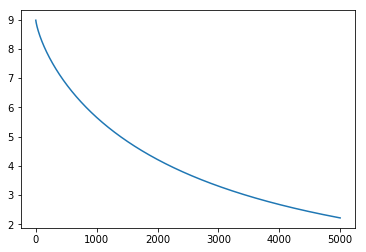

In [148]:
plt.plot(range(len(costs_4)),costs_4)

<Figure size 432x288 with 0 Axes>

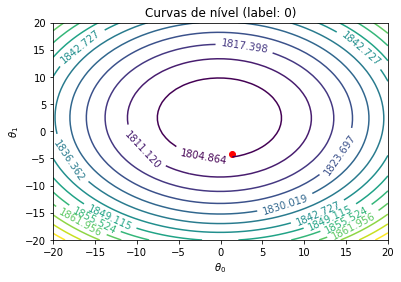

In [149]:
scores,costs, theta = utils.sim_parallel_sgd(X_train_pca, y_train_pca, X_test_pca, y_test_pca, n_iter, n_jobs, split_per_job=1/n_jobs, overlap=False)
utils.plot_contour(X_test_pca, y_test_pca, theta)

20 workers:

In [150]:
n_jobs = 20
%time scores_20, costs_20, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 4min 6s, sys: 2.94 s, total: 4min 9s
Wall time: 2min 4s


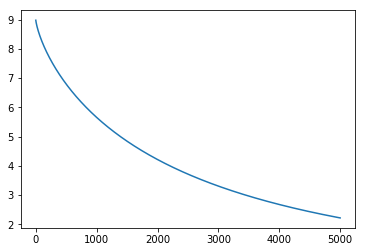

In [151]:
plt.plot(range(len(costs_20)),costs_20)

<Figure size 432x288 with 0 Axes>

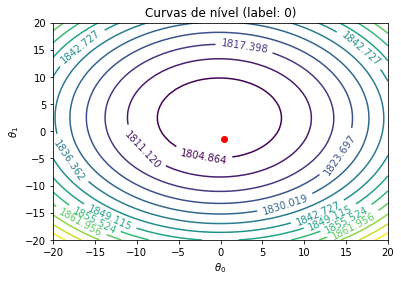

In [152]:
scores,costs, theta = utils.sim_parallel_sgd(X_train_pca, y_train_pca, X_test_pca, y_test_pca, n_iter, n_jobs, split_per_job=1/n_jobs, overlap=False)
utils.plot_contour(X_test_pca, y_test_pca, theta)

50 workers:

In [153]:
n_jobs = 50
%time scores_50, costs_50, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 10min 26s, sys: 7.93 s, total: 10min 34s
Wall time: 5min 19s


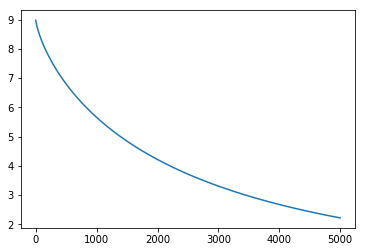

In [154]:
plt.plot(range(len(costs_50)),costs_50)

In [ ]:
scores,costs, theta = utils.sim_parallel_sgd(X_train_pca, y_train_pca, X_test_pca, y_test_pca, n_iter, n_jobs, split_per_job=1/n_jobs, overlap=False)
utils.plot_contour(X_test_pca, y_test_pca, theta)

100 workers:

In [ ]:
n_jobs = 100
%time scores_100, costs_100, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

In [ ]:
plt.plot(range(len(costs_100)),costs_100)

In [ ]:
scores,costs, theta = utils.sim_parallel_sgd(X_train_pca, y_train_pca, X_test_pca, y_test_pca, n_iter, n_jobs, split_per_job=1/n_jobs, overlap=False)
utils.plot_contour(X_test_pca, y_test_pca, theta)

In [ ]:
plt.figure(1)
for s in [costs_4, costs_20, costs_50, costs_100]:
    plt.plot(range(len(s)),s, '--')

### Cenário 3:
Neste cenário uma porcentagem dos dados é distribuída a cada worker. O mesmo exemplo pode ser acessado por mais de um deles (overlap). A sincronização é feita apenas ao final.

50% dos dados para cada worker:

In [ ]:
n_jobs = 4
%time scores, costs, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=0.5, overlap=True)

In [ ]:
plt.plot(range(len(costs)),costs)

In [ ]:
scores,costs, theta = utils.sim_parallel_sgd(X_train_pca, y_train_pca, X_test_pca, y_test_pca, n_iter, n_jobs, split_per_job=0.5, overlap=True)
utils.plot_contour(X_test_pca, y_test_pca, theta)

25% dos dados para cada worker:

In [ ]:
n_jobs = 4
%time scores, costs,theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=0.25, overlap=True)

In [ ]:
plt.plot(range(len(costs)),costs)

In [ ]:
scores,costs, theta = utils.sim_parallel_sgd(X_train_pca, y_train_pca, X_test_pca, y_test_pca, n_iter, n_jobs, split_per_job=0.25, overlap=True)
utils.plot_contour(X_test_pca, y_test_pca, theta)

### Cenário 4:
No cenário 4, todos os workers processam todo o conjunto de dados, mas a sincronização dos resultados é feita não apenas ao final, mas também durante o processamento.

Com 2 sincronizações:

In [ ]:
importlib.reload(utils)

In [ ]:
n_jobs = 4
n_sync = 2
%time scores_2_sync, costs_2_sync, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

In [ ]:
plt.plot(range(len(costs_2_sync)),costs_2_sync)

Com 4 sincronizações:

In [ ]:
scores,costs, theta = utils.sim_parallel_sgd(X_train_pca, y_train_pca, X_test_pca, y_test_pca, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)
utils.plot_contour(X_test_pca, y_test_pca, theta)

In [ ]:
n_jobs = 4
n_sync = 4
%time scores_4_sync, costs_4_sync, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

In [ ]:
plt.plot(range(len(costs_4_sync)),costs_4_sync)

In [ ]:
scores,costs, theta = utils.sim_parallel_sgd(X_train_pca, y_train_pca, X_test_pca, y_test_pca, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)
utils.plot_contour(X_test_pca, y_test_pca, theta)

Com 5 sicncronizações:

In [ ]:
n_jobs = 4
n_sync = 5
%time scores_5_sync, costs_5_sync, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

In [ ]:
plt.plot(range(len(costs_5_sync)),costs_5_sync)

In [ ]:
scores,costs, theta = utils.sim_parallel_sgd(X_train_pca, y_train_pca, X_test_pca, y_test_pca, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)
utils.plot_contour(X_test_pca, y_test_pca, theta)

Com 10 sincronizações:

In [ ]:
n_jobs = 4
n_sync = 10
%time scores_10_sync, costs_10_sync, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

In [ ]:
plt.plot(range(len(costs_10_sync)),costs_10_sync)

In [ ]:
scores,costs, theta = utils.sim_parallel_sgd(X_train_pca, y_train_pca, X_test_pca, y_test_pca, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)
utils.plot_contour(X_test_pca, y_test_pca, theta)

Comparativo dos testes:

In [ ]:
plt.figure(1)
plt.plot(range(len(cost_base)), cost_base)
for s in [costs_2_sync, costs_4_sync, costs_5_sync, costs_10_sync]:
    plt.plot(range(len(s)), s, '--')